<a href="https://colab.research.google.com/github/katybohanan/5542-cnn-hands-on/blob/main/mnist_CNN_with_Gemini_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load Required Libraries

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

##Load and Preprocess Data

In [33]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


trainset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)


testset = torchvision.datasets.MNIST(root='./data',
                                    train=False,
                                    download=True,
                                    transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=False)

##Define CNN model

In [34]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x


model = CNN()

##Train the Model

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
  running_loss = 0.0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.4804255133316775
Epoch 2, Loss: 0.11316388838918535
Epoch 3, Loss: 0.06017048520504669


##Evaluate Performance

In [36]:
correct = 0
total = 0

with torch.no_grad():
  for images, labels in testloader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total: .2f}%")

Accuracy on the test set:  98.81%


##Make a Prediction on an Image

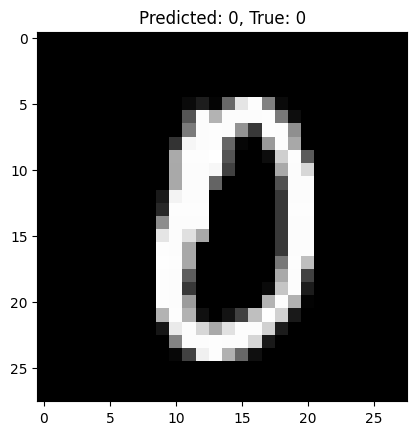

In [37]:
import random
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = next(dataiter)
index = random.randint(0, len(images) - 1)
img = images[index].squeeze()
true_label = labels[index].item()
output = model(images[index].unsqueeze(0))
predicted_label = torch.argmax(output).item()

plt.imshow(img.numpy(), cmap='gray')
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()

##Connect with Gemini API

In [38]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
GEMINI_ENDPOINT = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent"

headers = {
    "Content-Type": "application/json"
}

data = {
    "contents": [{"parts": [{"text": f"The CNN model predicted digit {predicted_label} for an image. Explain why it might have made this prediction."}]}]
}

response = requests.post(f"{GEMINI_ENDPOINT}?key={GEMINI_API_KEY}",
                        headers=headers, json=data)

# Check for successful response before accessing data
if response.status_code == 200:
    explanation = response.json()["candidates"][0].get("content", {}).get("parts", [{}])[0].get("text", "No explanation available.")  # Safely access nested keys
    print("Gemini Explanation: ", explanation)
else:
    print(f"Error: {response.status_code} - {response.text}")  # Print error details for debugging

Gemini Explanation:  A CNN might predict the digit 0 for an image even if it's not actually a 0 due to several reasons:

**1. Image Quality Issues:**

* **Noise:** The image might contain noise (random variations in pixel intensity) that interferes with the CNN's ability to accurately identify features.  Noise can distort the shape and characteristics of the digit, leading to a misclassification.
* **Blur:** A blurry image lacks sharp edges and details, making it difficult for the CNN to distinguish between digits.  A blurred 8, for instance, might look enough like a 0 to confuse the model.
* **Low Resolution:** Low-resolution images lack sufficient detail, causing the CNN to misinterpret the features.
* **Obscuration:** Part of the digit might be obscured or hidden by another object or shadow, making it harder for the CNN to recognize the complete shape.
* **Unusual Font or Style:** The digit's style (handwritten, printed, font type) might differ significantly from the styles the CNN 

##CIFAR-10 Classification

In [39]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


trainset = torchvision.datasets.CIFAR10(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)


testset = torchvision.datasets.CIFAR10(root='./data',
                                    train=False,
                                    download=True,
                                    transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
class CIFARCNN(nn.Module):
  def __init__(self):
    super(CIFARCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.fc1 = nn.Linear(64 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.pool(torch.relu(self.bn1(self.conv1(x))))
    x = self.pool(torch.relu(self.bn2(self.conv2(x))))
    x = x.view(-1, 64 * 8 * 8)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model_cifar = CIFARCNN()

##Train model

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)

for epoch in range(2):
  running_loss = 0.0
  for images, labels in trainloader:
    optimizer.zero_grad()
    outputs = model_cifar(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 1.604252337650129
Epoch 2, Loss: 1.2143414134432555


##Evaluate Performance

In [42]:
correct = 0
total = 0

with torch.no_grad():
  for images, labels in testloader:
    outputs = model_cifar(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total: .2f}%")

Accuracy on the test set:  61.58%


##Make prediction

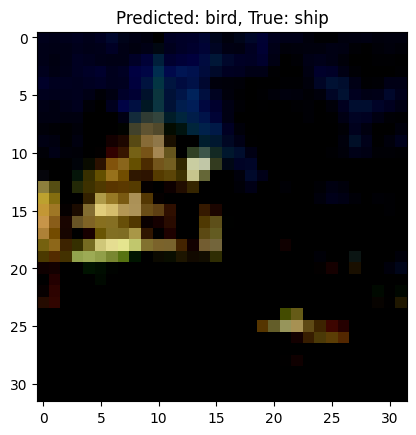

In [43]:
import random
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = next(dataiter)
index = random.randint(0, len(images) - 1)
img = images[index].squeeze()
true_label = labels[index].item()
true_label = trainset.classes[true_label]
output = model_cifar(images[index].unsqueeze(0))
predicted_label = torch.argmax(output).item()
predicted_label = trainset.classes[predicted_label]

# Permute the dimensions of the image to (height, width, channels)
img = img.permute(1, 2, 0)

plt.imshow(img.numpy())
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [44]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
GEMINI_ENDPOINT = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent"

headers = {
    "Content-Type": "application/json"
}

data = {
    "contents": [{"parts": [{"text": f"The CNN model predicted digit {predicted_label} for an image. Explain why it might have made this prediction."}]}]
}

response = requests.post(f"{GEMINI_ENDPOINT}?key={GEMINI_API_KEY}",
                        headers=headers, json=data)

# Check for successful response before accessing data
if response.status_code == 200:
    explanation = response.json()["candidates"][0].get("content", {}).get("parts", [{}])[0].get("text", "No explanation available.")  # Safely access nested keys
    print("Gemini Explanation: ", explanation)
else:
    print(f"Error: {response.status_code} - {response.text}")  # Print error details for debugging

Gemini Explanation:  A CNN model predicting "digit bird" for an image suggests a fascinating failure mode stemming from a combination of factors:

* **Feature Confusion:** CNNs learn features hierarchically.  Lower layers might detect simple edges and curves, while higher layers combine these into more complex shapes like circles, lines, and angles.  A digit (especially certain handwritten ones like 0, 6, or 8) and a bird (depending on the angle and style of the image) might share low-level features.  The CNN might have incorrectly linked these overlapping low-level features to both categories, leading to a hallucinated combination.  For example, a circular shape in the image could be interpreted as both the body of a bird and the loop of a digit 0 or 6.

* **Insufficient Training Data:** If the training dataset lacked sufficient examples of birds and digits that looked similar, the model may not have learned to adequately distinguish them, especially in cases of ambiguous or noisy ima